#Data Preparation

In [3]:
import numpy
import math
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import GRU
from keras.layers import LSTM

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import tensorflow as tf


pd.set_option("display.max_rows", 1000)#可显示1000行
pd.set_option("display.max_columns", 1000)#可显示1000列
%matplotlib inline

In [4]:
from google.colab import drive
drive.mount('/content/drive/')
import os
os.chdir("/content/drive/My Drive/CA683 Assignment2")
df = pd.read_csv('Premier League_2014_2022.csv')
df = df[df['ranking']!='None']

Mounted at /content/drive/


In [5]:
MOVING_AVERAGE = 5
MINIMUM_RECORD = 160

In [6]:
dict_player = {}
dict_player_name = {}
for player_id in df['player_id'].unique():
  list_rate = list(df[df['player_id']==player_id]['ranking'].astype(float).rolling(MOVING_AVERAGE).mean())
  if(len(list_rate)>=MINIMUM_RECORD):
    dict_player[player_id] = list_rate[MOVING_AVERAGE-1:]
    dict_player_name[player_id] = df[df['player_id']==player_id]['player_name'].unique()[0]

In [7]:
import random
test_player_list = random.sample(dict_player_name.keys(), 10)
test_player_list

[15485, 3708, 1439, 51581, 6374, 3110, 477, 350545, 2600, 16836]

In [8]:
test_player_list = [49180, 28867, 15509, 51581, 37046, 46854, 15485, 59481, 24473, 22689]

# MODEL&CONFIG

In [ ]:
def create_inout_sequences(input_data, tw):
    feature_seq = []
    result_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]#预测time_step之后的第一个数值
        feature_seq.append(train_seq)#feature_seq内的数据不断更新，但是总量只有tw个
        result_seq.append(train_label)

    return feature_seq,result_seq
def cal_rmsle(predicted,real):
  sum=0.0
  for x in range(len(predicted)):
    p = np.log(predicted[x]+1)
    r = np.log(real[x]+1)
    sum = sum + (p - r)**2
  return (sum/len(predicted))**0.5

In [ ]:
class MODEL_CONFIG:
  TEST_DATA_SIZE = 20
  INITIAL_WINDOW = 80
  WINDOW_LENTH = 20
  Filename = './Comparison_Work/Result.csv'
  Foldername = './Comparison_Work/Pic_Comparison/'
  def __init__(self, \
        LEARNING_RATE = 0.001,\
        TIME_STEP = 10,\
        DENSE = 1,\
        NUM_NODES = 30,\
        EPOCHS = 500,\
        STRUCTURE = 'RNN',\
        OPTIMIZER = 'SGD'):
    self.LEARNING_RATE = LEARNING_RATE
    self.TIME_STEP = TIME_STEP
    self.DENSE = DENSE
    self.NUM_NODES = NUM_NODES
    self.EPOCHS = EPOCHS
    self.STRUCTURE = STRUCTURE
    if OPTIMIZER == "SGD":
      self.OPTIMIZER = tf.keras.optimizers.SGD(learning_rate=LEARNING_RATE, decay=1e-6, momentum=0.9, nesterov=True)
    if OPTIMIZER == "ADAM":
      self.OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE,beta_1=0.9,beta_2=0.999,epsilon=1e-07,amsgrad=False)
    if OPTIMIZER == "RMSprop":
      self.OPTIMIZER = tf.keras.optimizers.RMSprop(learning_rate=LEARNING_RATE,rho=0.9,momentum=0.0,epsilon=1e-07,centered=False)

In [ ]:
def sliding_cv_fit(data, config, cur_player_id):
  list_mae = []
  list_mse = []
  list_r2 = []
  list_rmsle = []
  list_passtime = []
  #set model
  model = Sequential()
  if config.STRUCTURE == 'RNN':
    model.add(SimpleRNN(config.NUM_NODES, input_shape=(1, config.TIME_STEP)))
  else:
    if config.STRUCTURE == 'GRU':
      model.add(GRU(config.NUM_NODES, input_shape=(1, config.TIME_STEP)))
    else:
      model.add(LSTM(config.NUM_NODES, input_shape=(1, config.TIME_STEP)))
  model.add(Dense(config.DENSE))
  model.compile(loss='mean_squared_error', optimizer=config.OPTIMIZER)


  list_train_pred = []
  list_test_pred = []

  for train_mark in range(config.INITIAL_WINDOW, (len(data)//config.WINDOW_LENTH)*config.WINDOW_LENTH, config.WINDOW_LENTH):
    data_piece = data[train_mark - config.INITIAL_WINDOW : train_mark + config.WINDOW_LENTH]
    data_seq,result_seq = create_inout_sequences(data_piece, config.TIME_STEP)
    
    train_X = np.array(data_seq[:-config.TEST_DATA_SIZE])
    test_X = np.array(data_seq[-config.TEST_DATA_SIZE:])
    train_Y = np.array(result_seq[:-config.TEST_DATA_SIZE])
    test_Y = np.array(result_seq[-config.TEST_DATA_SIZE:])
    
    train_X = np.reshape(train_X, (train_X.shape[0],1,train_X.shape[1]))
    test_X = np.reshape(test_X, (test_X.shape[0],1,test_X.shape[1]))

    T1 = time.time()
    model.fit(train_X, train_Y, epochs=config.EPOCHS, batch_size=1, verbose=0)
    pass_time = time.time() - T1

    trainPredict = model(train_X)
    testPredict = model(test_X)
    if train_mark == config.INITIAL_WINDOW:
      list_train_pred = list_train_pred + list(trainPredict[:,0])
    else:
      list_train_pred = list_train_pred + list(trainPredict[:,0][-config.WINDOW_LENTH:])

    list_test_pred = list_test_pred + list(testPredict[:,0])

    list_mae.append(mean_absolute_error(test_Y, testPredict))
    list_mse.append(mean_squared_error(test_Y, testPredict))
    list_r2.append(r2_score(test_Y, testPredict))
    list_rmsle.append(cal_rmsle(test_Y, testPredict))
    list_passtime.append(pass_time)
  #create figure
  fig_len = len(data) // 10 + 2
  plt.figure(figsize=[fig_len,6])
  plt.plot(range(0,len(data)),data,color='blue')
  len_trainP = len(list_train_pred)
  len_testP = len(list_test_pred)
  plt.plot(range(config.TIME_STEP,config.TIME_STEP+len_trainP),list_train_pred,color='orange')
  plt.plot(range(config.INITIAL_WINDOW,config.INITIAL_WINDOW+len_testP),list_test_pred,color='red')
  plt.legend(['Real', 'Train Predict', 'Test Predict'],loc='best')
  plt.title('Performance of ' + dict_player_name[cur_player_id])

  plt.savefig(config.Foldername + str(cur_player_id) + '.jpg')
  print('\nSave fig to:' + config.Foldername + str(cur_player_id) + '.jpg')
  #plt.show()

  return np.mean(list_mae),np.mean(list_mse),np.mean(list_r2),np.mean(list_rmsle),np.mean(list_passtime)

#RNN

In [ ]:
df_RNN_para = pd.read_csv('./Comparison_Work/RNN_ParaResultCV.csv')
df_RNN_para = df_RNN_para.sort_values(by="MSE",ascending=True)
print(df_RNN_para[0:5])

    LEARNING_RATE  TIME_STEP  DENSE  NUM_NODES  EPOCHS OPTIMIZER  TIME_STEP.1  \
9           0.001          6      1         40     400      ADAM          NaN   
21          0.001          7      1         40     400      ADAM          NaN   
3           0.001          6      1         20     500      ADAM          NaN   
23          0.001          7      1         40     500      ADAM          NaN   
7           0.001          6      1         30     500      ADAM          NaN   

         MAE       MSE     RMSLE        R2  
9   0.187822  0.065101  0.030805  0.514504  
21  0.205720  0.071732  0.033416  0.327540  
3   0.218230  0.072009  0.034048  0.234984  
23  0.206363  0.074220  0.032909  0.368549  
7   0.218965  0.074643  0.034163  0.258224  


In [ ]:
config_RNN = MODEL_CONFIG(0.001,6,1,40,400,'RNN','ADAM')
config_RNN.Filename = './Comparison_Work/TrainSet80/RNN_Result.csv'
config_RNN.Foldername = './Comparison_Work/TrainSet80/Pic_RNN/'

 10%|█         | 1/10 [04:13<37:57, 253.09s/it]


Save fig to:./Comparison_Work/LargerTrainSet/Pic_RNN/49180.jpg

	TIME_PER_TRAIN(Second):63.01271069049835

	MAE:0.2159181826114653
	MSE:0.07280523611617137
	R2:0.731721027598466
	RMSLE:0.03246685311285647


 20%|██        | 2/10 [09:11<37:20, 280.02s/it]


Save fig to:./Comparison_Work/LargerTrainSet/Pic_RNN/28867.jpg

	TIME_PER_TRAIN(Second):59.70240302085877

	MAE:0.19384287776947032
	MSE:0.06354739589645841
	R2:0.5876353600546166
	RMSLE:0.03316800559147613


 30%|███       | 3/10 [16:18<40:28, 346.93s/it]


Save fig to:./Comparison_Work/LargerTrainSet/Pic_RNN/15509.jpg

	TIME_PER_TRAIN(Second):60.87042079653059

	MAE:0.21203118828364778
	MSE:0.07108036667948256
	R2:0.028202803162071226
	RMSLE:0.031984133778039645


 40%|████      | 4/10 [19:53<29:27, 294.66s/it]


Save fig to:./Comparison_Work/LargerTrainSet/Pic_RNN/51581.jpg

	TIME_PER_TRAIN(Second):53.54174757003784

	MAE:0.20804081344604486
	MSE:0.06609609593997862
	R2:-1.2997715468519995
	RMSLE:0.032990911126389605


 50%|█████     | 5/10 [28:12<30:43, 368.63s/it]


Save fig to:./Comparison_Work/LargerTrainSet/Pic_RNN/37046.jpg

	TIME_PER_TRAIN(Second):71.33203973088946

	MAE:0.20329671205793112
	MSE:0.06737523459957372
	R2:0.45765577429795357
	RMSLE:0.03218796484398503


 60%|██████    | 6/10 [32:19<21:49, 327.28s/it]


Save fig to:./Comparison_Work/LargerTrainSet/Pic_RNN/46854.jpg

	TIME_PER_TRAIN(Second):82.21069184939067

	MAE:0.15223729165395103
	MSE:0.03796432361818251
	R2:0.4078432674879837
	RMSLE:0.02527951687995573


 70%|███████   | 7/10 [36:12<14:48, 296.29s/it]


Save fig to:./Comparison_Work/LargerTrainSet/Pic_RNN/15485.jpg

	TIME_PER_TRAIN(Second):46.40568623542786

	MAE:0.17658431701660163
	MSE:0.04960969284392438
	R2:0.35836861117575913
	RMSLE:0.03019260700455832


 80%|████████  | 8/10 [41:35<10:09, 304.97s/it]


Save fig to:./Comparison_Work/LargerTrainSet/Pic_RNN/59481.jpg

	TIME_PER_TRAIN(Second):64.62171964645385

	MAE:0.2244819812774656
	MSE:0.07544285672359051
	R2:0.29273119272041165
	RMSLE:0.03442085938749784


 90%|█████████ | 9/10 [47:18<05:16, 316.77s/it]


Save fig to:./Comparison_Work/LargerTrainSet/Pic_RNN/24473.jpg

	TIME_PER_TRAIN(Second):68.45976157188416

	MAE:0.18172557621002192
	MSE:0.051475880411179356
	R2:0.4293308395737256
	RMSLE:0.03046357435431617


100%|██████████| 10/10 [52:21<00:00, 314.12s/it]


Save fig to:./Comparison_Work/LargerTrainSet/Pic_RNN/22689.jpg

	TIME_PER_TRAIN(Second):60.426451444625854

	MAE:0.18662612266540526
	MSE:0.05515090862135762
	R2:0.11447396375131971
	RMSLE:0.030335014963681194


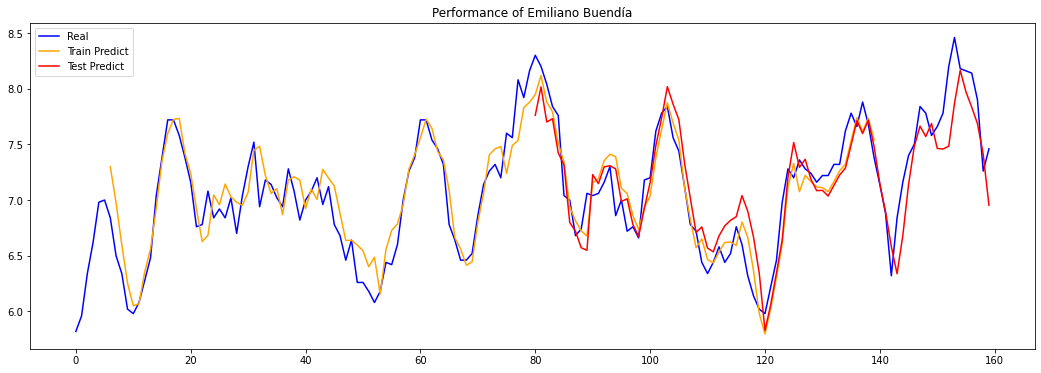

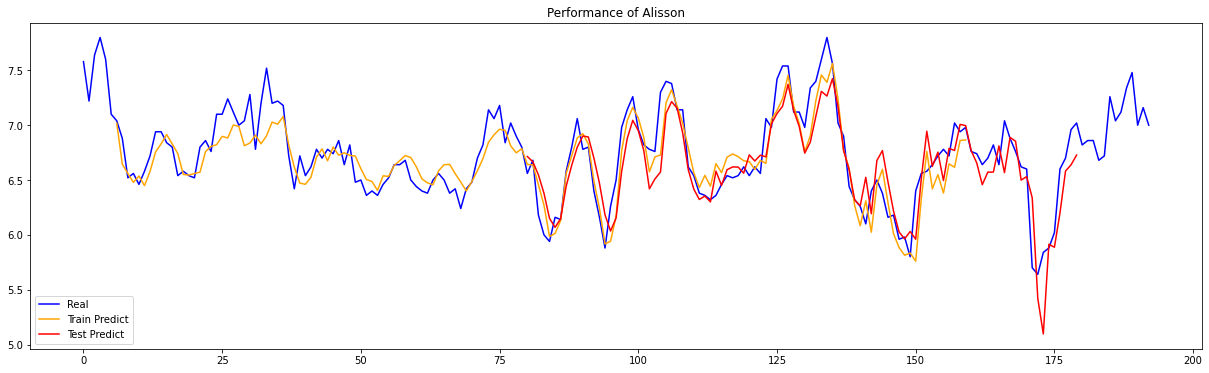

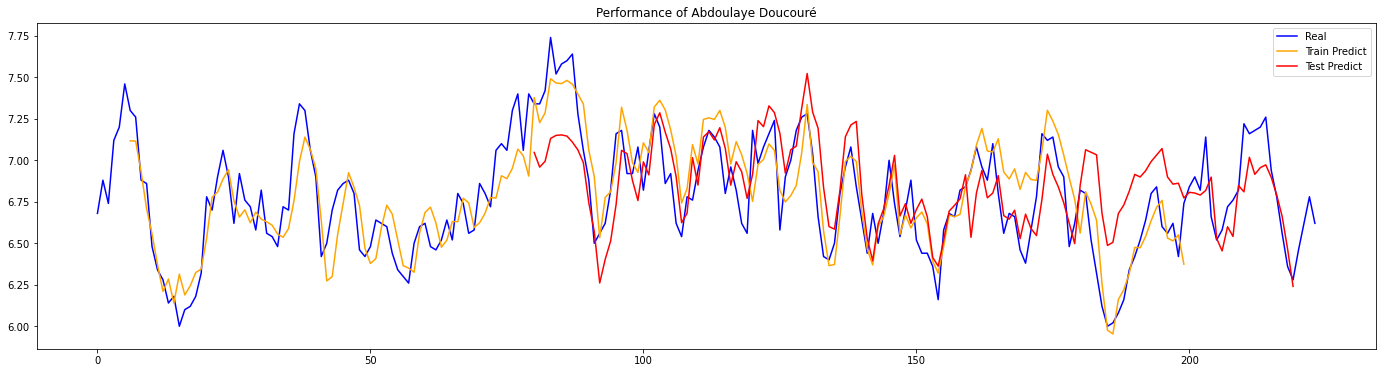

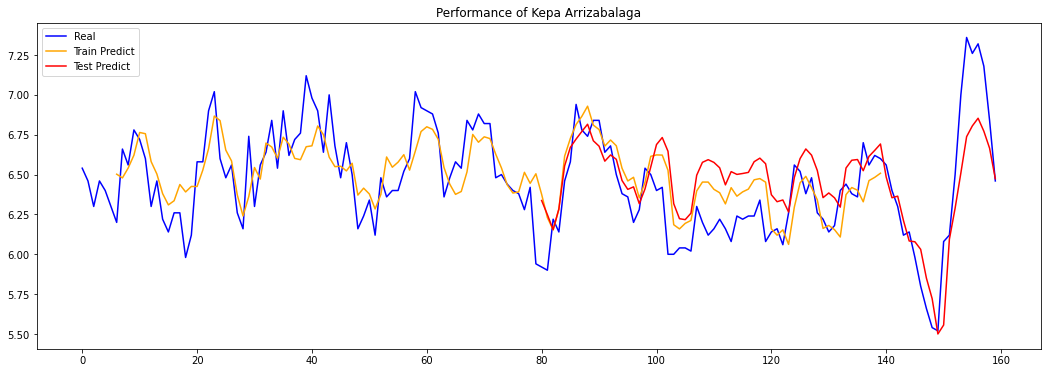

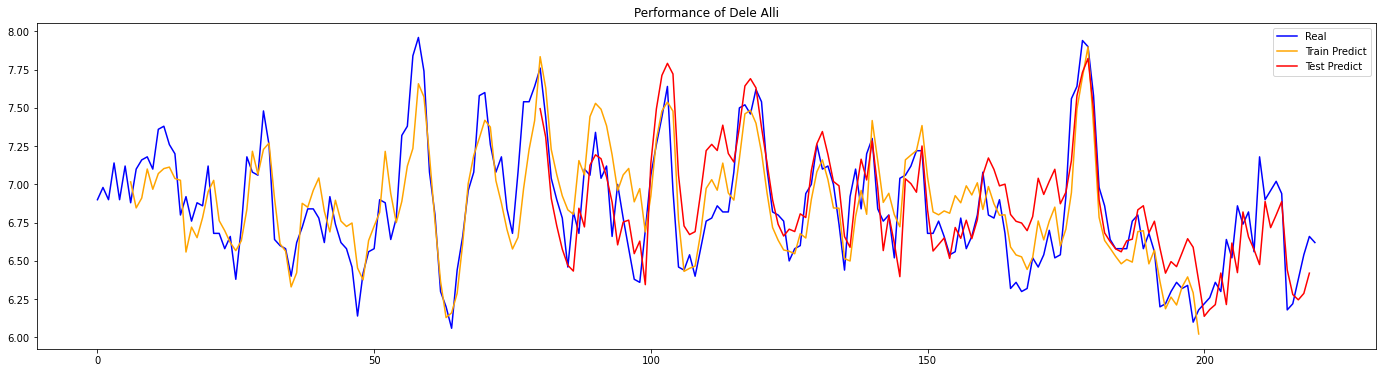

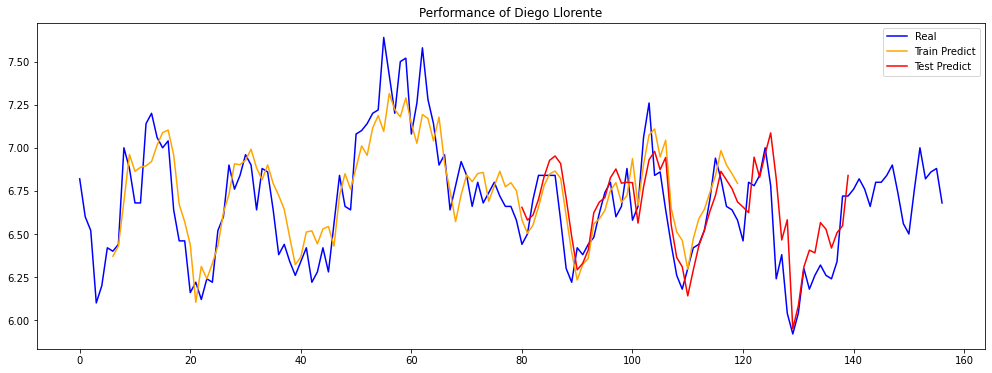

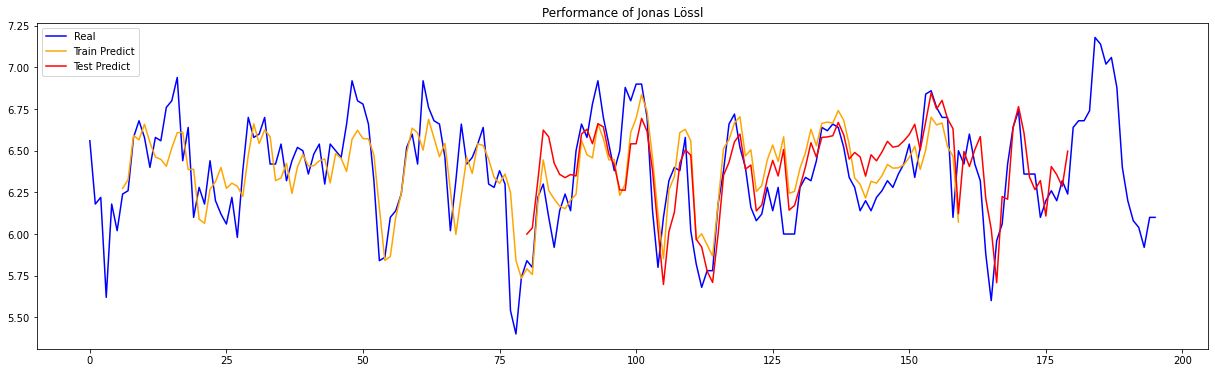

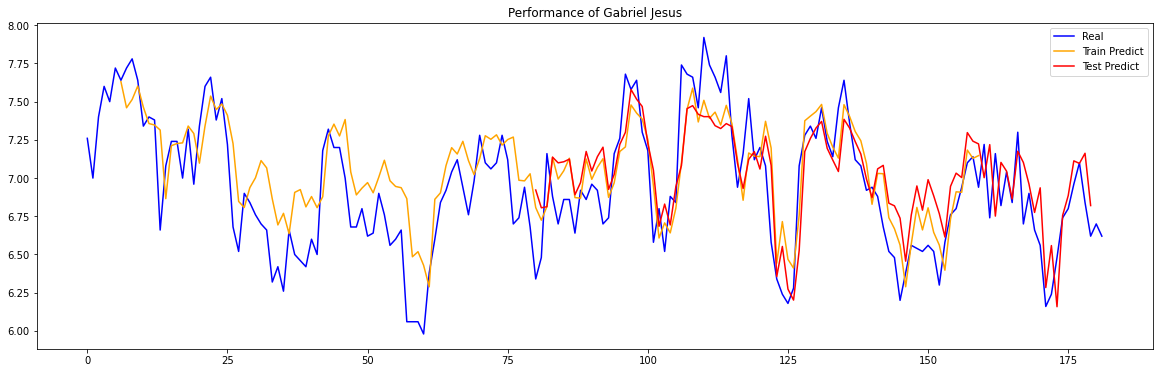

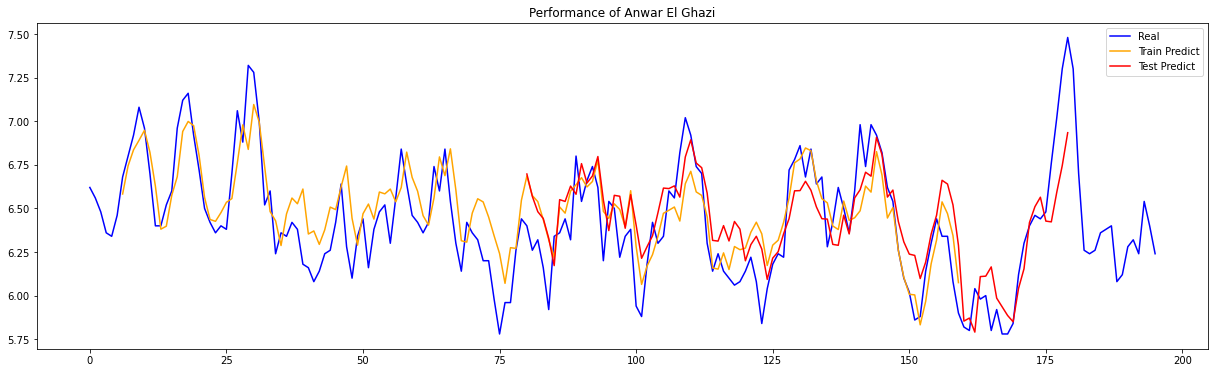

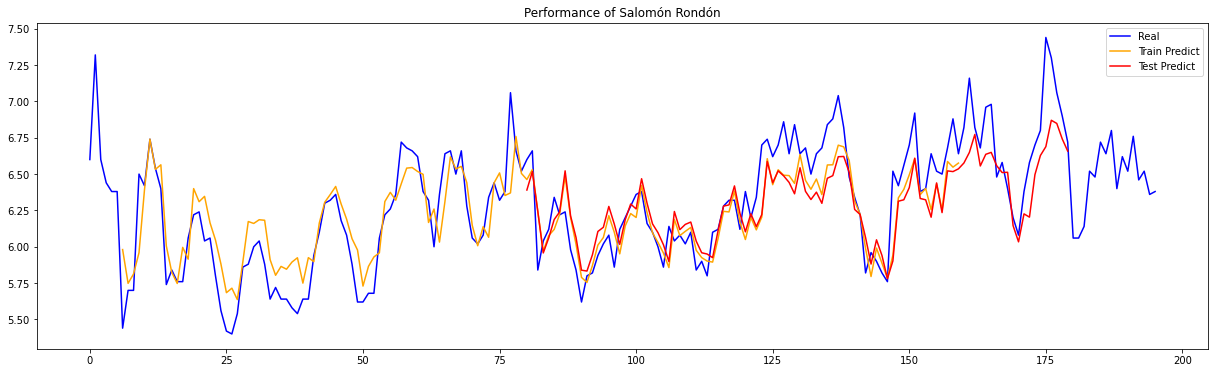

In [ ]:
df_result = pd.DataFrame(columns = ['NAME','ID','MAE','MSE','RMSLE','R2'],dtype = float)
for player_id in tqdm(test_player_list):
  data = dict_player[player_id]
  mae,mse,r2,rmsle,passtime = sliding_cv_fit(data, config_RNN, player_id)
  print('\n\tTIME_PER_TRAIN(Second):'+str(passtime))
  print('\n\tMAE:'+str(mae))
  print('\tMSE:'+str(mse))
  print('\tR2:'+str(r2))
  print('\tRMSLE:'+str(rmsle))
  df_result = df_result.append({'NAME':dict_player_name[player_id],\
        'ID':player_id,\
        'MAE':mae,\
        'MSE':mse,\
        'R2':r2,\
        'RMSLE':rmsle,\
        'LENGTH':len(data),\
        'TIME_PER_TRAIN':passtime},ignore_index='true')
df_result.to_csv(config_RNN.Filename,index=0)

#GRU

In [ ]:
df_GRU_para = pd.read_csv('./Comparison_Work/GRU_ParaResultCV.csv')
df_GRU_para = df_GRU_para.sort_values(by="MSE",ascending=True)
print(df_GRU_para[0:5])

    LEARNING_RATE  TIME_STEP  DENSE  NUM_NODES  EPOCHS OPTIMIZER  TIME_STEP.1  \
11          0.001          6      1         40     500      ADAM          NaN   
28          0.001          8      1         30     400       SGD          NaN   
23          0.001          7      1         40     500      ADAM          NaN   
9           0.001          6      1         40     400      ADAM          NaN   
7           0.001          6      1         30     500      ADAM          NaN   

         MAE       MSE     RMSLE        R2  
11  0.187576  0.061778  0.030586  0.512846  
28  0.190322  0.062103  0.031119  0.454427  
23  0.196848  0.062525  0.031652  0.370999  
9   0.189588  0.062596  0.030822  0.501661  
7   0.193299  0.062757  0.031032  0.417338  


In [ ]:
config_GRU = MODEL_CONFIG(0.001,6,1,40,500,'GRU','ADAM')
config_GRU.Filename = './Comparison_Work/TrainSet80/GRU_Result.csv'
config_GRU.Foldername = './Comparison_Work/TrainSet80/Pic_GRU/'

 10%|█         | 1/10 [06:17<56:39, 377.76s/it]


Save fig to:./Comparison_Work/LargerTrainSet/Pic_GRU/49180.jpg

	TIME_PER_TRAIN(Second):94.26896649599075

	MAE:0.19632334256172174
	MSE:0.061254627516273905
	R2:0.7708247887666159
	RMSLE:0.02942207827420619


 20%|██        | 2/10 [12:54<51:52, 389.06s/it]


Save fig to:./Comparison_Work/LargerTrainSet/Pic_GRU/28867.jpg

	TIME_PER_TRAIN(Second):79.27816853523254

	MAE:0.19387585086822495
	MSE:0.06104804235876886
	R2:0.5843550751686138
	RMSLE:0.03225118917238717


 30%|███       | 3/10 [21:53<53:22, 457.54s/it]


Save fig to:./Comparison_Work/LargerTrainSet/Pic_GRU/15509.jpg

	TIME_PER_TRAIN(Second):76.9110997404371

	MAE:0.2000447491237096
	MSE:0.058756380943074116
	R2:0.034691093508042066
	RMSLE:0.03042630175543903


 40%|████      | 4/10 [27:18<40:30, 405.12s/it]


Save fig to:./Comparison_Work/LargerTrainSet/Pic_GRU/51581.jpg

	TIME_PER_TRAIN(Second):81.0530993938446

	MAE:0.18744588589668276
	MSE:0.055583957078544646
	R2:-0.9549779564895194
	RMSLE:0.030289994109694615


 50%|█████     | 5/10 [35:52<37:02, 444.41s/it]


Save fig to:./Comparison_Work/LargerTrainSet/Pic_GRU/37046.jpg

	TIME_PER_TRAIN(Second):73.34711486952645

	MAE:0.17677968406677244
	MSE:0.04732407411990001
	R2:0.5607457892788261
	RMSLE:0.027661981068643572


 60%|██████    | 6/10 [39:01<23:49, 357.44s/it]


Save fig to:./Comparison_Work/LargerTrainSet/Pic_GRU/46854.jpg

	TIME_PER_TRAIN(Second):62.69390360514323

	MAE:0.16961836592356358
	MSE:0.04632564771922687
	R2:0.2675572997477035
	RMSLE:0.028126188404500096


 70%|███████   | 7/10 [45:24<18:17, 365.83s/it]


Save fig to:./Comparison_Work/LargerTrainSet/Pic_GRU/15485.jpg

	TIME_PER_TRAIN(Second):76.50654888153076

	MAE:0.1640899726867675
	MSE:0.04361262620587917
	R2:0.44928760521219085
	RMSLE:0.028057466407378284


 80%|████████  | 8/10 [51:20<12:05, 362.89s/it]


Save fig to:./Comparison_Work/LargerTrainSet/Pic_GRU/59481.jpg

	TIME_PER_TRAIN(Second):71.20529632568359

	MAE:0.18970219802856433
	MSE:0.06378469405903923
	R2:0.4884315383019212
	RMSLE:0.030988283431471197


 90%|█████████ | 9/10 [57:16<06:00, 360.58s/it]


Save fig to:./Comparison_Work/LargerTrainSet/Pic_GRU/24473.jpg

	TIME_PER_TRAIN(Second):70.98679962158204

	MAE:0.17112490253448492
	MSE:0.044057315501969375
	R2:0.5310137319331755
	RMSLE:0.027904868609140772


100%|██████████| 10/10 [1:03:28<00:00, 380.88s/it]


Save fig to:./Comparison_Work/LargerTrainSet/Pic_GRU/22689.jpg

	TIME_PER_TRAIN(Second):74.34485440254211

	MAE:0.14362012844085686
	MSE:0.03292344985203056
	R2:0.4825903630665621
	RMSLE:0.024119025628309188


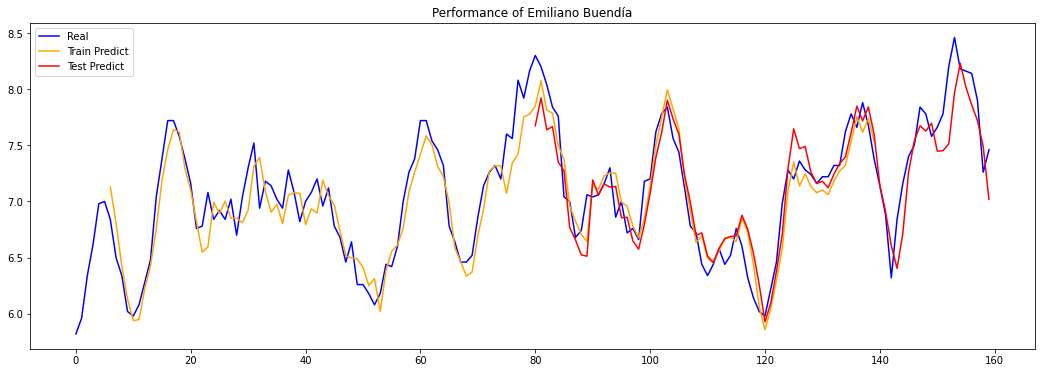

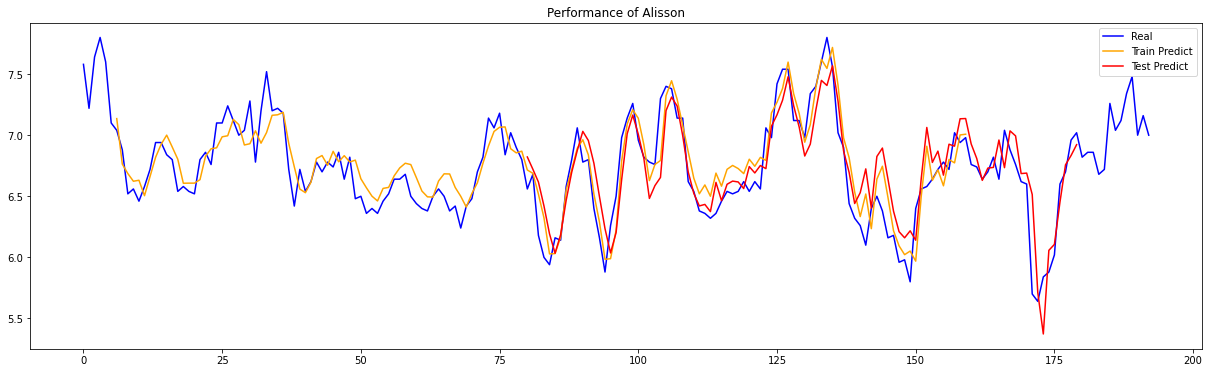

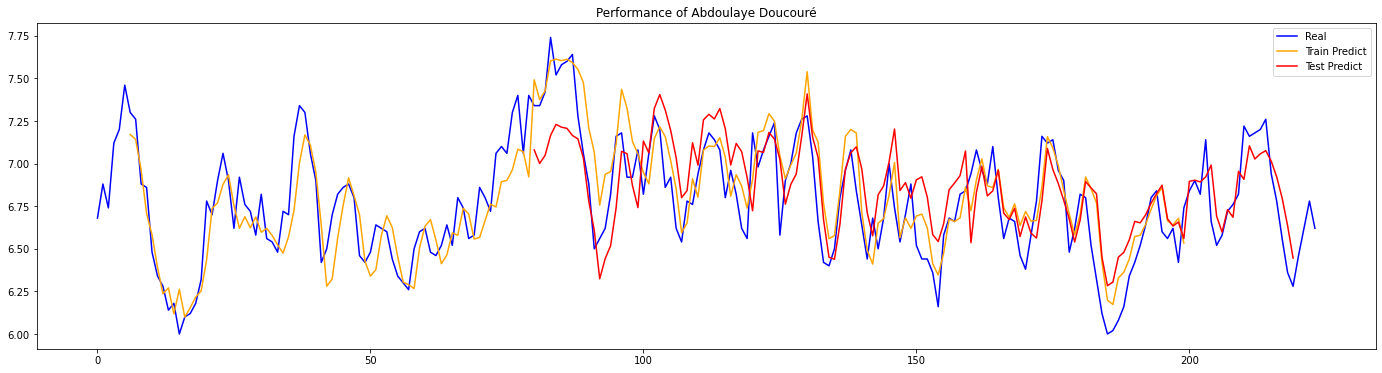

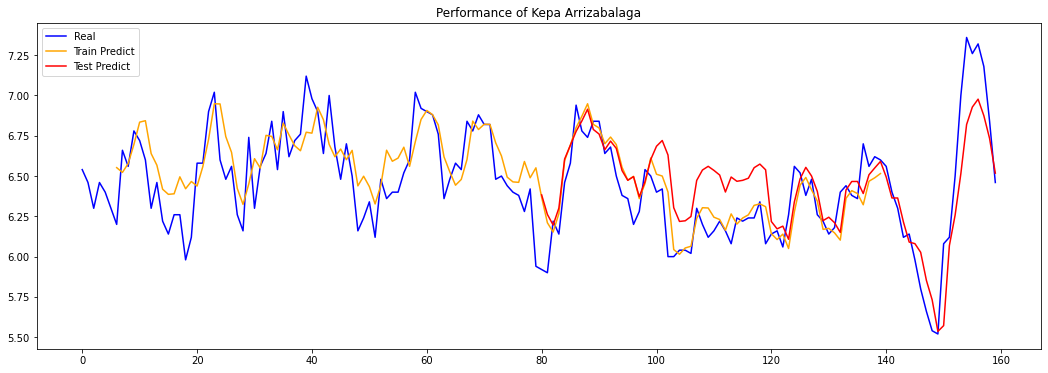

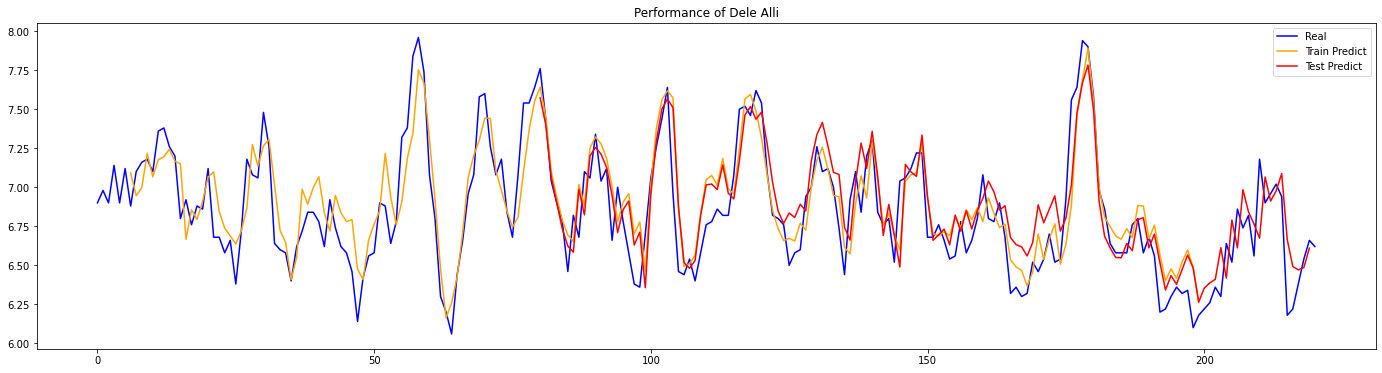

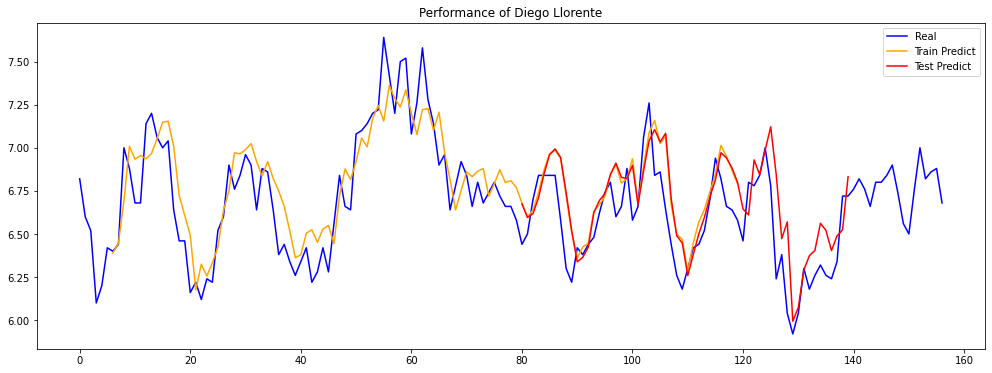

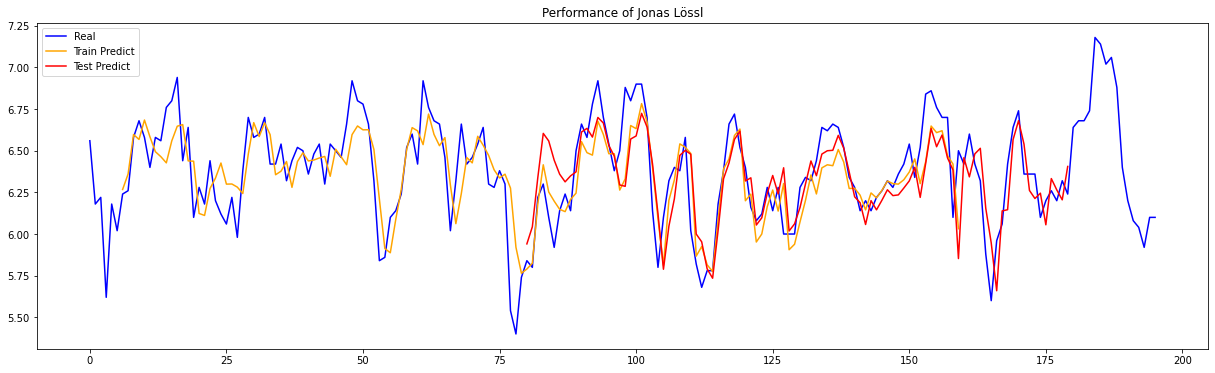

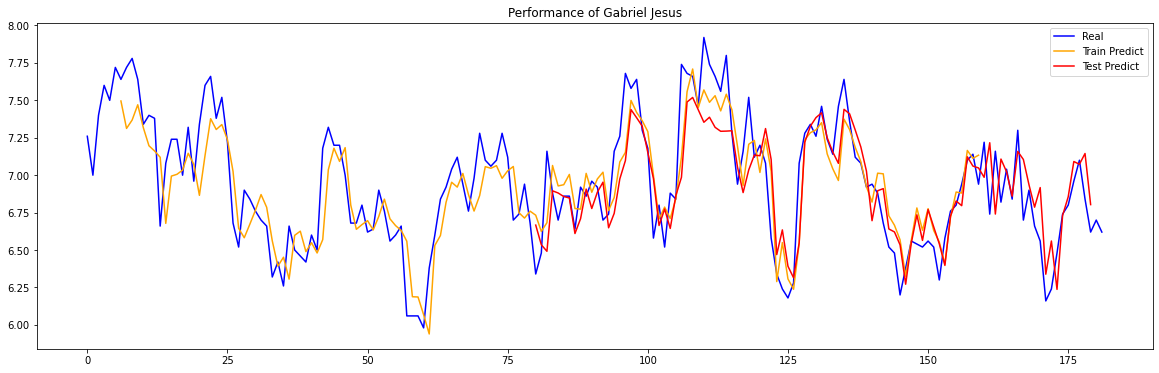

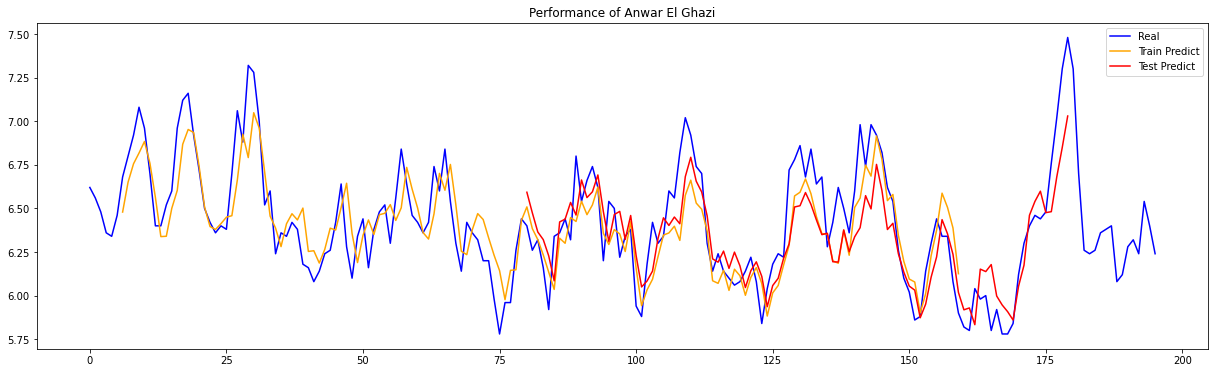

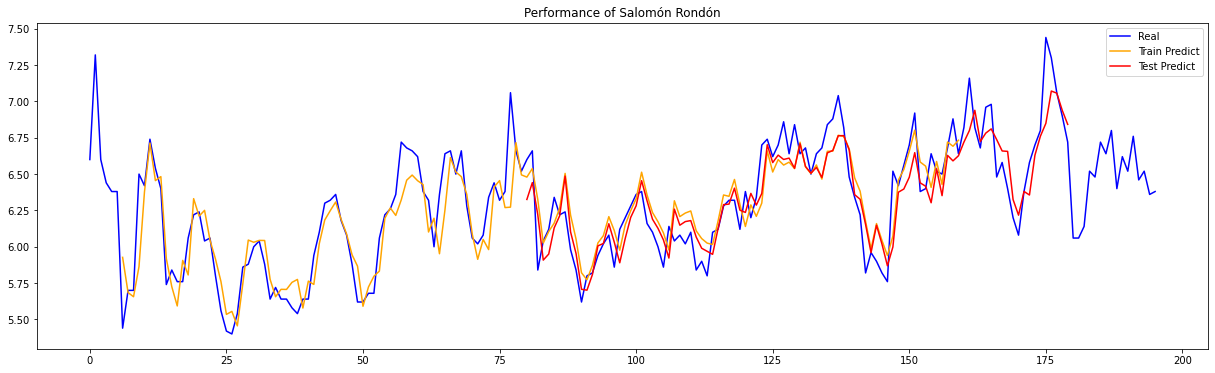

In [ ]:
df_result = pd.DataFrame(columns = ['NAME','ID','MAE','MSE','RMSLE','R2'],dtype = float)
for player_id in tqdm(test_player_list):
  data = dict_player[player_id]
  mae,mse,r2,rmsle,passtime = sliding_cv_fit(data, config_GRU, player_id)
  print('\n\tTIME_PER_TRAIN(Second):'+str(passtime))
  print('\n\tMAE:'+str(mae))
  print('\tMSE:'+str(mse))
  print('\tR2:'+str(r2))
  print('\tRMSLE:'+str(rmsle))
  df_result = df_result.append({'NAME':dict_player_name[player_id],\
        'ID':player_id,\
        'MAE':mae,\
        'MSE':mse,\
        'R2':r2,\
        'RMSLE':rmsle,\
        'LENGTH':len(data),\
        'TIME_PER_TRAIN':passtime},ignore_index='true')
df_result.to_csv(config_GRU.Filename,index=0)

#LSTM

In [ ]:
df_para = pd.read_csv('ParaResultCV.csv')
df_para = df_para.sort_values(by="MSE",ascending=True)
print(df_para[0:5])

    LEARNING_RATE  TIME_STEP  DENSE  NUM_NODES  EPOCHS OPTIMIZER  TIME_STEP.1  \
23          0.001          7      1         20     500      ADAM          NaN   
34          0.001          7      1         40     500       SGD          NaN   
9           0.001          6      1         30     400      ADAM          NaN   
3           0.001          6      1         20     400      ADAM          NaN   
32          0.001          7      1         40     400       SGD          NaN   

         MAE       MSE     RMSLE        R2  
23  0.179809  0.055023  0.029342  0.516331  
34  0.185452  0.057287  0.030016  0.476154  
9   0.188581  0.059201  0.030295  0.502503  
3   0.189823  0.061629  0.030634  0.485452  
32  0.189335  0.062664  0.030677  0.485385  


In [ ]:
config_LSTM = MODEL_CONFIG(0.001,7,1,20,500,'LSTM','ADAM')
config_LSTM.Filename = './Comparison_Work/TrainSet80/LSTM_Result.csv'
config_LSTM.Foldername = './Comparison_Work/TrainSet80/Pic_LSTM/'

 10%|█         | 1/10 [04:55<44:17, 295.24s/it]


Save fig to:./Comparison_Work/LargerTrainSet/Pic_LSTM/49180.jpg

	TIME_PER_TRAIN(Second):73.40602308511734

	MAE:0.20945830368995655
	MSE:0.06919666757201992
	R2:0.7479463594008906
	RMSLE:0.03156125604349756


 20%|██        | 2/10 [10:50<44:03, 330.42s/it]


Save fig to:./Comparison_Work/LargerTrainSet/Pic_LSTM/28867.jpg

	TIME_PER_TRAIN(Second):70.88771004676819

	MAE:0.2244029184341434
	MSE:0.08322851045070948
	R2:0.45687951337868427
	RMSLE:0.03776329695021535


 30%|███       | 3/10 [19:07<47:24, 406.38s/it]


Save fig to:./Comparison_Work/LargerTrainSet/Pic_LSTM/15509.jpg

	TIME_PER_TRAIN(Second):70.86734816006252

	MAE:0.18059629835401264
	MSE:0.0514614867010524
	R2:0.30931132105897075
	RMSLE:0.02772615527597023


 40%|████      | 4/10 [23:50<35:47, 357.90s/it]


Save fig to:./Comparison_Work/LargerTrainSet/Pic_LSTM/51581.jpg

	TIME_PER_TRAIN(Second):70.74010425806046

	MAE:0.2024226295948028
	MSE:0.06238322578212995
	R2:-1.600679229430721
	RMSLE:0.031972237954745776


 50%|█████     | 5/10 [32:10<34:06, 409.24s/it]


Save fig to:./Comparison_Work/LargerTrainSet/Pic_LSTM/37046.jpg

	TIME_PER_TRAIN(Second):71.36762990270343

	MAE:0.2176846414293562
	MSE:0.06742363918772057
	R2:0.3536220100686522
	RMSLE:0.03297161903512055


 60%|██████    | 6/10 [35:59<23:10, 347.75s/it]


Save fig to:./Comparison_Work/LargerTrainSet/Pic_LSTM/46854.jpg

	TIME_PER_TRAIN(Second):75.9451133410136

	MAE:0.1485926704406738
	MSE:0.03534550825317473
	R2:0.41155923350774953
	RMSLE:0.02471259652262392


 70%|███████   | 7/10 [42:27<18:03, 361.11s/it]


Save fig to:./Comparison_Work/LargerTrainSet/Pic_LSTM/15485.jpg

	TIME_PER_TRAIN(Second):77.58282785415649

	MAE:0.18201079826354977
	MSE:0.0590300644691021
	R2:0.3178545563020617
	RMSLE:0.03230632989639789


 80%|████████  | 8/10 [48:57<12:20, 370.31s/it]


Save fig to:./Comparison_Work/LargerTrainSet/Pic_LSTM/59481.jpg

	TIME_PER_TRAIN(Second):77.87011041641236

	MAE:0.23263731975555416
	MSE:0.08439317136504824
	R2:0.236348419179774
	RMSLE:0.03582274059728329


 90%|█████████ | 9/10 [54:58<06:07, 367.15s/it]


Save fig to:./Comparison_Work/LargerTrainSet/Pic_LSTM/24473.jpg

	TIME_PER_TRAIN(Second):71.90287609100342

	MAE:0.16831062126159668
	MSE:0.04327267041326506
	R2:0.5392175122678264
	RMSLE:0.027686001878441047


100%|██████████| 10/10 [1:01:18<00:00, 367.82s/it]


Save fig to:./Comparison_Work/LargerTrainSet/Pic_LSTM/22689.jpg

	TIME_PER_TRAIN(Second):75.88188962936401

	MAE:0.160994602394104
	MSE:0.04078255085862605
	R2:0.3688291605195463
	RMSLE:0.02667848304547212


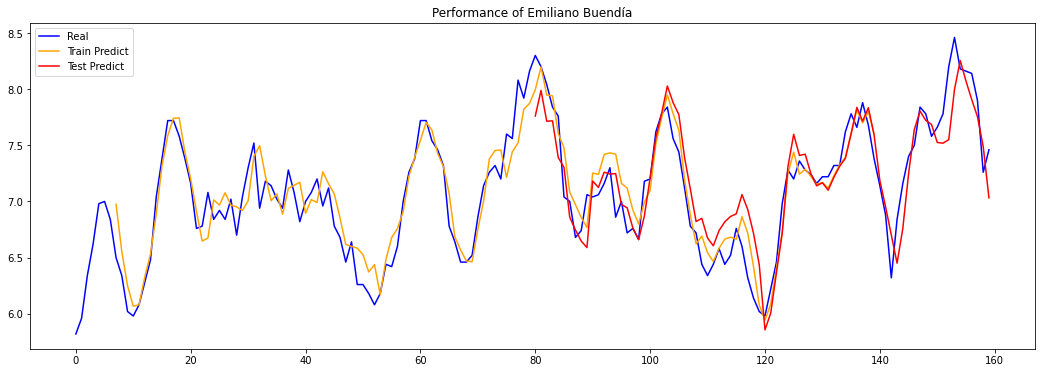

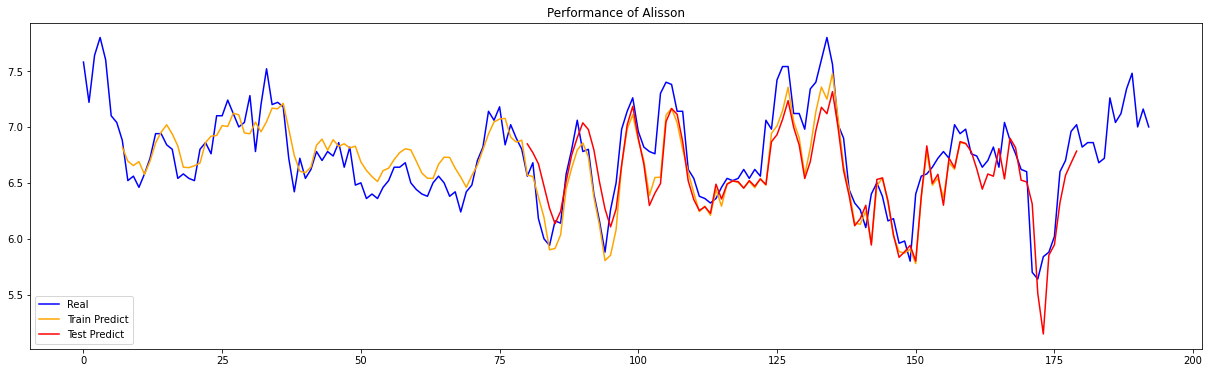

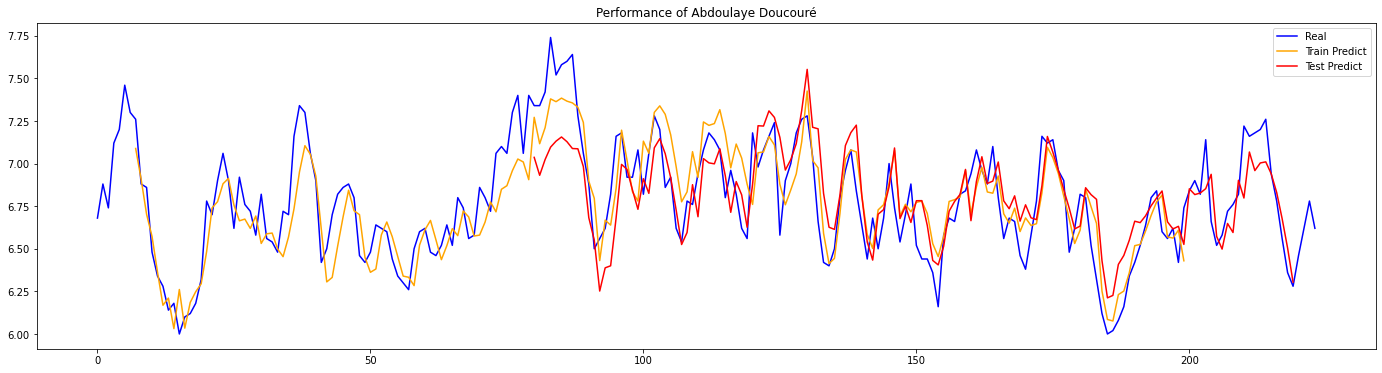

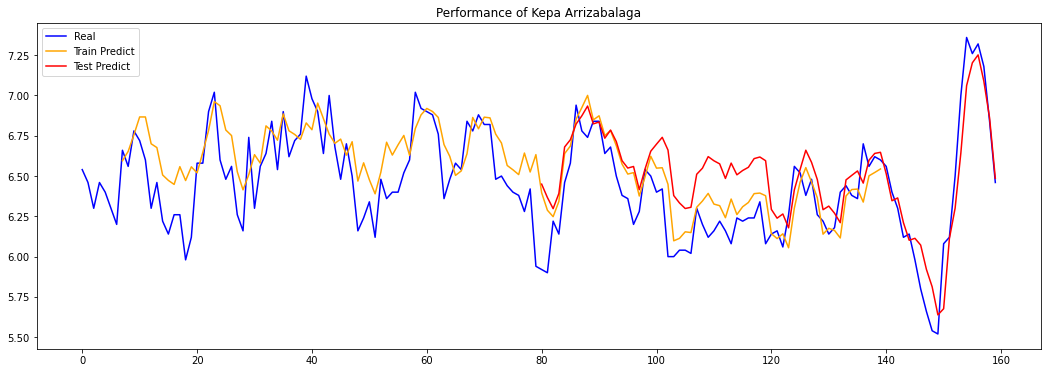

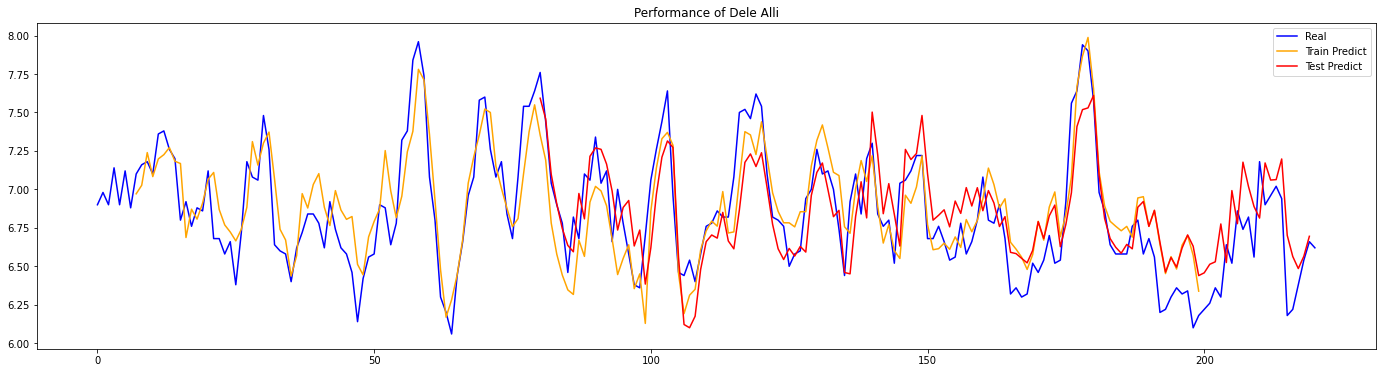

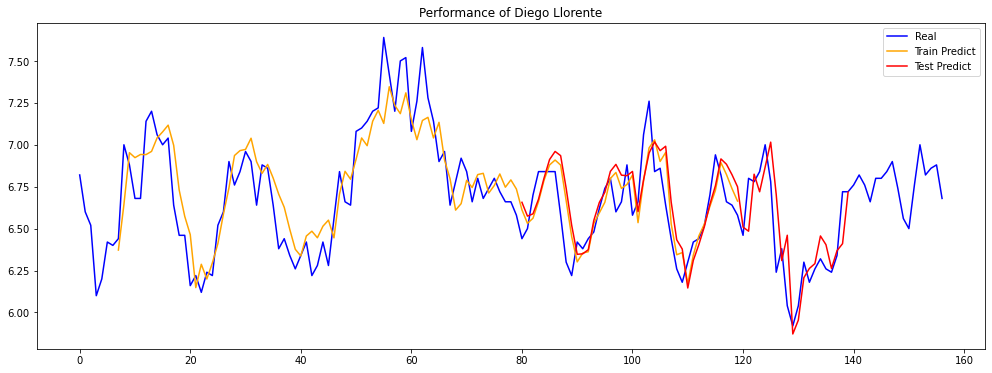

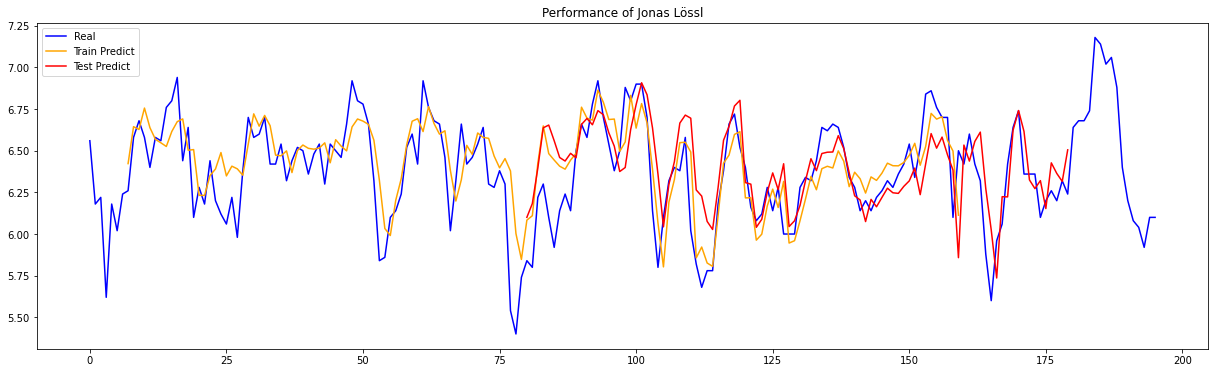

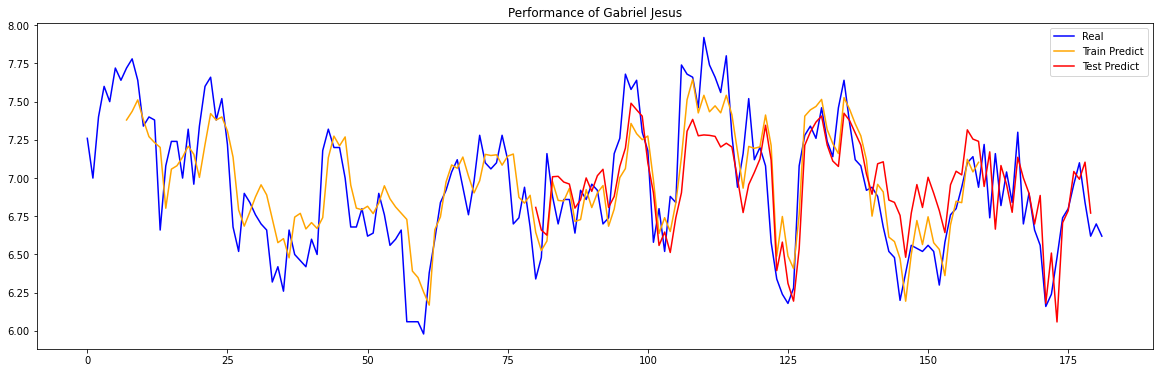

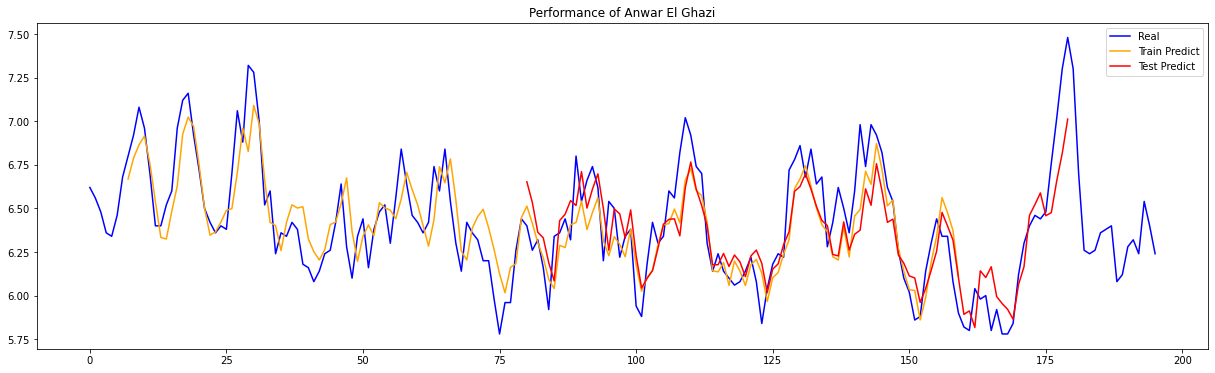

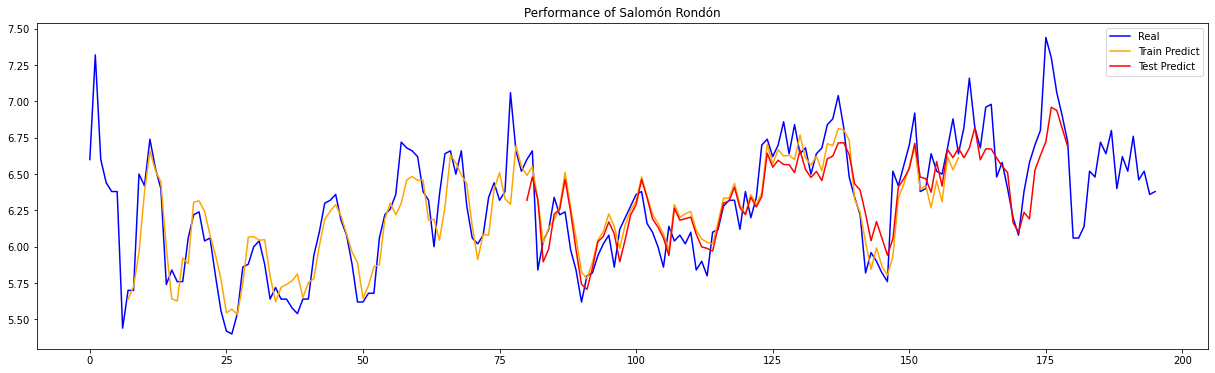

In [ ]:
df_result = pd.DataFrame(columns = ['NAME','ID','MAE','MSE','RMSLE','R2'],dtype = float)
for player_id in tqdm(test_player_list):
  data = dict_player[player_id]
  mae,mse,r2,rmsle,passtime = sliding_cv_fit(data, config_LSTM, player_id)
  print('\n\tTIME_PER_TRAIN(Second):'+str(passtime))
  print('\n\tMAE:'+str(mae))
  print('\tMSE:'+str(mse))
  print('\tR2:'+str(r2))
  print('\tRMSLE:'+str(rmsle))
  df_result = df_result.append({'NAME':dict_player_name[player_id],\
        'ID':player_id,\
        'MAE':mae,\
        'MSE':mse,\
        'R2':r2,\
        'RMSLE':rmsle,\
        'LENGTH':len(data),\
        'TIME_PER_TRAIN':passtime},ignore_index='true')
df_result.to_csv(config_LSTM.Filename,index=0)